# Improving function approximation by adjusting tuning curves

This tutorial shows how adjusting the tuning curves of neurons
can help implement specific functions with Nengo.
As an example we will try to to compute
the Heaviside step function,
which is 1 for all $x > 0$ and 0 otherwise.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import nengo

## The naive approach

As a first pass, we can try to implement the Heaviside step function
using an ensemble with default parameters.

In [2]:
n_neurons = 150
duration = 2.0

In [3]:
def stimulus_fn(t):
    return (2.0 * t / duration) - 1.0


def heaviside(x):
    return x > 0

In [4]:
with nengo.Network() as model_naive:
    stimulus = nengo.Node(stimulus_fn)
    ens = nengo.Ensemble(n_neurons=n_neurons, dimensions=1)
    output = nengo.Node(size_in=1)

    nengo.Connection(stimulus, ens)
    nengo.Connection(ens, output, function=heaviside)

    p_naive = nengo.Probe(output, synapse=0.005)

In [5]:
with nengo.Simulator(model_naive) as sim_naive:
    sim_naive.run(duration)

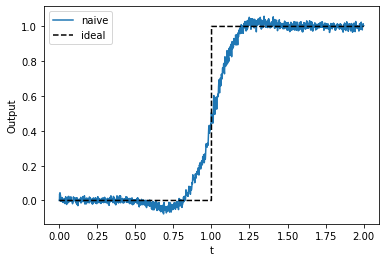

In [6]:
t = sim_naive.trange()
plt.figure()
plt.plot(t, sim_naive.data[p_naive], label="naive")
plt.plot(t, heaviside(stimulus_fn(t)), "--", c="black", label="ideal")
plt.xlabel("t")
plt.ylabel("Output")
plt.legend(loc="best")

We see that this approach does work,
but there is room for improvement.

## Investigating the tuning curves

Let us take a look at
the tuning curves of the neurons in the ensemble.

Text(0, 0.5, 'Firing rate [Hz]')

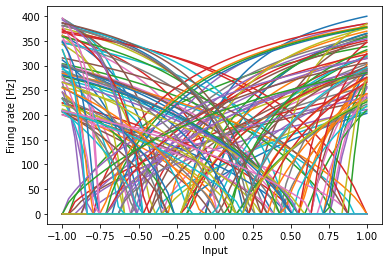

In [7]:
plt.figure()
plt.plot(*nengo.utils.ensemble.tuning_curves(ens, sim_naive))
plt.xlabel("Input")
plt.ylabel("Firing rate [Hz]")

About half of these neurons are tuned to fire more for smaller values.
But these values are not relevant
for the Heaviside step function,
since the output is always 0
when input is less than 0.
We can change all neurons to be tuned
to fire more for larger values
by setting all the encoders to be positive.

In [8]:
with nengo.Network() as model_pos_enc:
    stimulus = nengo.Node(stimulus_fn)
    ens = nengo.Ensemble(
        n_neurons=n_neurons, dimensions=1, encoders=nengo.dists.Choice([[1.0]])
    )
    output = nengo.Node(size_in=1)

    nengo.Connection(stimulus, ens)
    nengo.Connection(ens, output, function=heaviside)

    p_pos_enc = nengo.Probe(output, synapse=0.005)

In [9]:
with nengo.Simulator(model_pos_enc) as sim_pos_enc:
    sim_pos_enc.run(duration)

The resulting tuning curves:

Text(0, 0.5, 'Firing rate [Hz]')

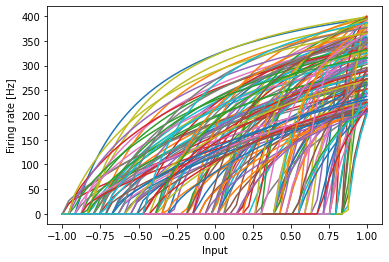

In [10]:
plt.figure()
plt.plot(*nengo.utils.ensemble.tuning_curves(ens, sim_pos_enc))
plt.xlabel("Input")
plt.ylabel("Firing rate [Hz]")

And the resulting decoded Heaviside step function:

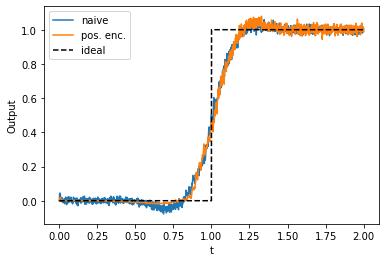

In [11]:
t = sim_pos_enc.trange()
plt.figure()
plt.plot(t, sim_naive.data[p_naive], label="naive")
plt.plot(t, sim_pos_enc.data[p_pos_enc], label="pos. enc.")
plt.plot(t, heaviside(stimulus_fn(t)), "--", c="black", label="ideal")
plt.xlabel("t")
plt.ylabel("Output")
plt.legend(loc="best")

Compared to the naive approach,
the representation of outputs lower than 1 is less noisy,
but otherwise there is little improvement.
Even though the tuning curves are all positive,
they are still covering a lot of irrelevant parts of the input space.
Because all outputs should be 0 when input is less than 0,
there is no need to have neurons tuned to inputs less than 0.
Let's shift all the intercepts to the range $(0.0, 1.0)$.

## Intercept distributions

Not only can the range of intercepts be important,
but also the distribution of intercepts.
Let us take a look at the Heaviside step function:

(-0.1, 1.1)

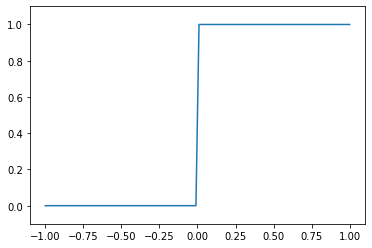

In [12]:
xs = np.linspace(-1, 1, 100)
plt.figure()
plt.plot(xs, heaviside(xs))
plt.ylim(-0.1, 1.1)

This function is mostly constant,
except for the large jump at 0.
The constant parts are easy to approximate
and do not need a lot of neural resources,
but the highly nonlinear jump
requires more neural resources
for an accurate representation.

Let us compare the thresholding of a scalar in three ways:

1. With a uniform distribution of intercepts (the default)
2. With all intercepts at 0 (where we have the nonlinearity)
3. With an exponential distribution

The last approach is in between
the two extremes of a uniform distribution
and placing all intercepts at 0.
It will distribute most intercepts close to 0,
but some intercepts will still be at larger values.

In [13]:
threshold = 0.0

with nengo.Network() as model_dists:
    stimulus = nengo.Node(stimulus_fn)
    ens_uniform = nengo.Ensemble(
        n_neurons=n_neurons,
        dimensions=1,
        encoders=nengo.dists.Choice([[1]]),
        intercepts=nengo.dists.Uniform(threshold, 1.0),
    )
    ens_fixed = nengo.Ensemble(
        n_neurons=n_neurons,
        dimensions=1,
        encoders=nengo.dists.Choice([[1]]),
        intercepts=nengo.dists.Choice([threshold]),
    )
    ens_exp = nengo.Ensemble(
        n_neurons=n_neurons,
        dimensions=1,
        encoders=nengo.dists.Choice([[1]]),
        intercepts=nengo.dists.Exponential(0.15, threshold, 1.0),
    )

    out_uniform = nengo.Node(size_in=1)
    out_fixed = nengo.Node(size_in=1)
    out_exp = nengo.Node(size_in=1)

    nengo.Connection(stimulus, ens_uniform)
    nengo.Connection(stimulus, ens_fixed)
    nengo.Connection(stimulus, ens_exp)
    nengo.Connection(ens_uniform, out_uniform, function=heaviside)
    nengo.Connection(ens_fixed, out_fixed, function=heaviside)
    nengo.Connection(ens_exp, out_exp, function=heaviside)

    p_uniform = nengo.Probe(out_uniform, synapse=0.005)
    p_fixed = nengo.Probe(out_fixed, synapse=0.005)
    p_exp = nengo.Probe(out_exp, synapse=0.005)

In [14]:
with nengo.Simulator(model_dists) as sim_dists:
    sim_dists.run(duration)

Let us look at the tuning curves first.

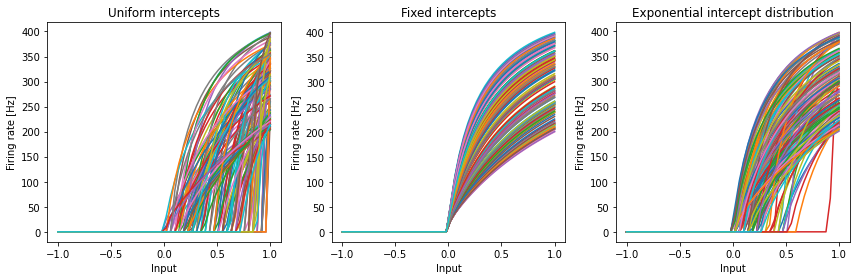

In [15]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(*nengo.utils.ensemble.tuning_curves(ens_uniform, sim_dists))
plt.xlabel("Input")
plt.ylabel("Firing rate [Hz]")
plt.title("Uniform intercepts")

plt.subplot(1, 3, 2)
plt.plot(*nengo.utils.ensemble.tuning_curves(ens_fixed, sim_dists))
plt.xlabel("Input")
plt.ylabel("Firing rate [Hz]")
plt.title("Fixed intercepts")

plt.subplot(1, 3, 3)
plt.plot(*nengo.utils.ensemble.tuning_curves(ens_exp, sim_dists))
plt.xlabel("Input")
plt.ylabel("Firing rate [Hz]")
plt.title("Exponential intercept distribution")

plt.tight_layout()

Now let us look at how these three ensembles
approximate the thresholding function.

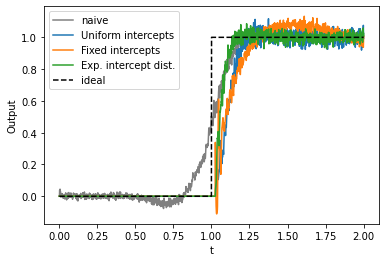

In [16]:
t = sim_dists.trange()
plt.figure()
plt.plot(t, sim_naive.data[p_naive], label="naive", c="gray")
plt.plot(t, sim_dists.data[p_uniform], label="Uniform intercepts")
plt.plot(t, sim_dists.data[p_fixed], label="Fixed intercepts")
plt.plot(t, sim_dists.data[p_exp], label="Exp. intercept dist.")
plt.plot(t, heaviside(stimulus_fn(t)), "--", c="black", label="ideal")
plt.xlabel("t")
plt.ylabel("Output")
plt.legend(loc="best")

We see that the fixed intercepts
produce slightly higher decoded values close to the threshold,
but the slope is lower than for uniform intercepts.
The best approximation of the thresholding
is done with the exponential intercept distribution.
Here we get a quick rise to 1 at the threshold
and a fairly constant representation of 1
for inputs sufficiently above 0.
All three distributions perfectly represent values below 0.

Nengo provides the `ThresholdingEnsemble` preset
to make it easier to assign intercepts
according to the exponential distribution,
and also adjusts the encoders and evaluation points accordingly.

In [17]:
with nengo.Network() as model_final:
    stimulus = nengo.Node(stimulus_fn)
    with nengo.presets.ThresholdingEnsembles(0.0):
        ens = nengo.Ensemble(n_neurons=n_neurons, dimensions=1)
    output = nengo.Node(size_in=1)

    nengo.Connection(stimulus, ens)
    nengo.Connection(ens, output, function=heaviside)

    p_final = nengo.Probe(output, synapse=0.005)

In [18]:
with nengo.Simulator(model_final) as sim_final:
    sim_final.run(duration)

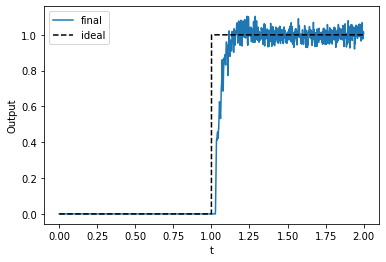

In [19]:
t = sim_final.trange()
plt.figure()
plt.plot(t, sim_final.data[p_final], label="final")
plt.plot(t, heaviside(stimulus_fn(t)), "--", c="black", label="ideal")
plt.xlabel("t")
plt.ylabel("Output")
plt.legend(loc="best")

## The takeaway

Adjusting ensemble parameters in the right way
can sometimes help in implementing functions more acurately in neurons.
Think about how your function maps from
the input vector space to the output vector space,
and consider ways to modify ensemble parameters
to better cover important parts
of the input vector space.